# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps. 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [25]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [26]:
# ohlc = yf.download(tickers, period="max")
# prices = ohlc["Adj Close"]
# prices.tail()
file_path = '../tests/resources/wine.csv'
prices = pd.read_csv(file_path, parse_dates=True, index_col="Unnamed: 0")


In [27]:
# market_prices = yf.download("SPY", period="max")["Adj Close"]
# market_prices.head()
file_path = '../tests/resources/000300.SH.csv'
market_prices = pd.read_csv(file_path, parse_dates=True, index_col="Unnamed: 0")
market_prices.head()

,CLOSE
2020-01-20,4185.8304
2020-01-21,4114.3085
2020-01-22,4131.9311
2020-01-23,4003.9013
2020-02-03,3688.3578


In [36]:
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
file_path = '../tests/resources/market_cap.csv'
market_cap = pd.read_csv(file_path, header=None, sep = ',')
mcaps = {}
for index, row in market_cap.iterrows():
    mcaps[row[1]] = locale.atof(row[2])/1000000
#     print(type(locale.atof(row[2])))
mcaps

{'600519.SH': 2401850.1936,
 '000858.SZ': 818242.967454,
 '000568.SZ': 336731.94670764,
 '600809.SH': 338886.766823,
 '002304.SZ': 242640.13788,
 '000799.SZ': 57837.35844,
 '600132.SH': 61706.327745,
 '000596.SZ': 94242.571044,
 '600600.SH': 98782.91779903701,
 '002568.SZ': 35449.840568160005,
 '688660.SH': 14613.334064}

## Constructing the prior

In [37]:
import pypfopt
pypfopt.__version__

'1.5.1'

In [38]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

CLOSE    1.714185
dtype: float64

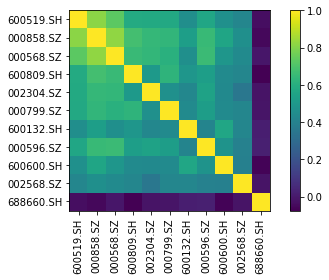

In [39]:
plotting.plot_covariance(S, plot_correlation=True);

In [40]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

000568.SZ   NaN
000596.SZ   NaN
000799.SZ   NaN
000858.SZ   NaN
002304.SZ   NaN
002568.SZ   NaN
600132.SH   NaN
600519.SH   NaN
600600.SH   NaN
600809.SH   NaN
688660.SH   NaN
CLOSE       NaN
dtype: float64

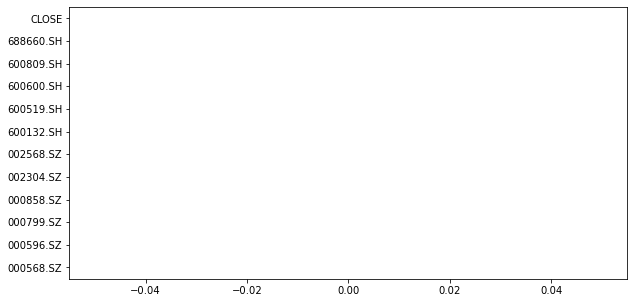

In [23]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [12]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

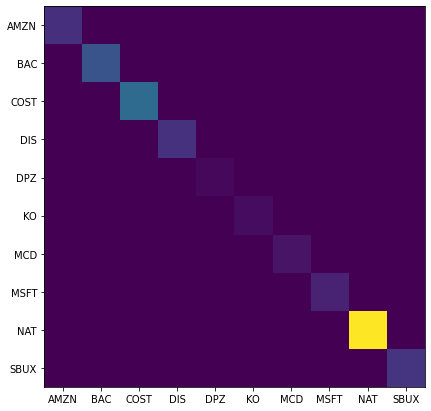

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0.0045905 , 0.00898597, 0.01212048, 0.00498592, 0.00080656,
       0.00116796, 0.00175348, 0.00344722, 0.03449912, 0.00538453])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [16]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [17]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [18]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [19]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.162904
BAC     0.135479
COST    0.060633
DIS     0.074979
DPZ     0.101862
KO      0.007067
MCD     0.104183
MSFT    0.102650
NAT     0.060905
SBUX    0.083113
dtype: float64

We can visualise how this compares to the prior and our views:

In [20]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.188493,0.162904,0.10
BAC,0.103315,0.135479,0.30
COST,0.075241,0.060633,0.05
DIS,0.097337,0.074979,0.05
DPZ,0.047762,0.101862,0.20
KO,0.062470,0.007067,-0.05
MCD,0.067165,0.104183,0.15
MSFT,0.131621,0.102650,0.10
NAT,0.051900,0.060905,0.50
SBUX,0.080227,0.083113,0.10


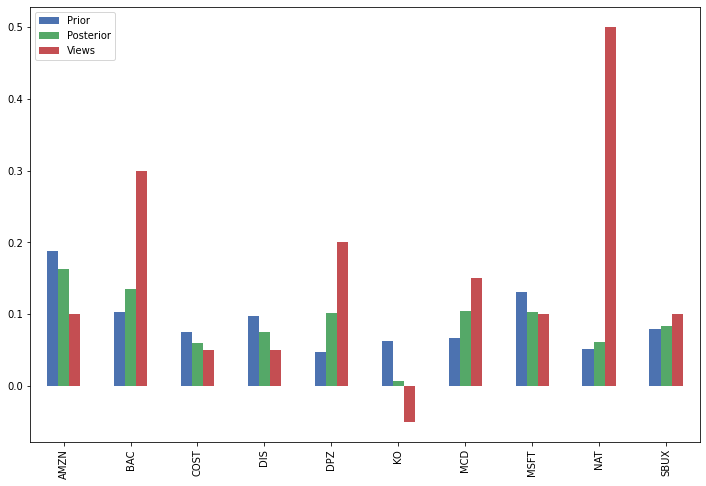

In [21]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

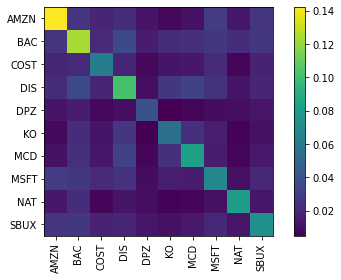

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [23]:
from pypfopt import EfficientFrontier, objective_functions

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/Robert/github/PyPortfolioOpt/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.20569),
             ('BAC', 0.1621),
             ('COST', 0.0521),
             ('DIS', 0.06778),
             ('DPZ', 0.129),
             ('KO', 0.0),
             ('MCD', 0.12415),
             ('MSFT', 0.11823),
             ('NAT', 0.05504),
             ('SBUX', 0.08591)])

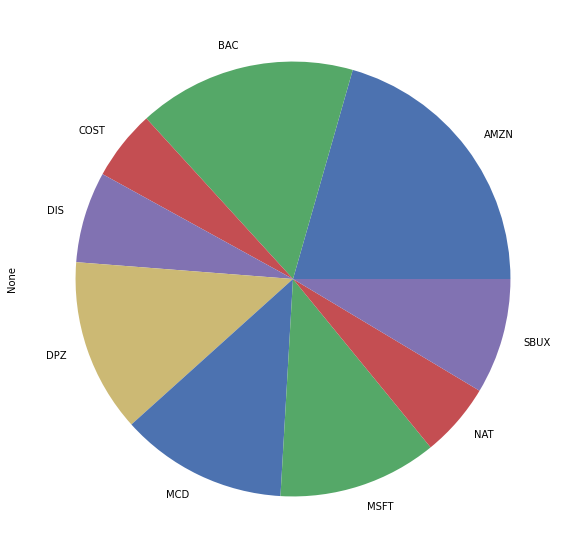

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $523.11


{'AMZN': 1,
 'BAC': 107,
 'COST': 3,
 'DIS': 8,
 'DPZ': 7,
 'MCD': 13,
 'MSFT': 10,
 'NAT': 387,
 'SBUX': 18}